# **The Energy Structure of Prime Numbers and the Function $F_E(x)$**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Construction of the DataFrame with Prime Energies**

In [2]:
# Importing the Necessary Libraries
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import os

from scipy.optimize import curve_fit


In [3]:
path_files = "/content/drive/MyDrive/spectral_structure_primes/data"
path_figures = "/content/drive/MyDrive/spectral_structure_primes/figures/en"


In [4]:
# Nomes dos arquivos
primes_file = f"{path_files}/primes_10_million.csv"
gammas_file = f"{path_files}/gamma_10_million.csv"


In [5]:
# Check if the files exist
if not os.path.exists(primes_file) or not os.path.exists(gammas_file):
    print("File(s) not found.")
    print("Please run the notebook '01_prime_counting_function.ipynb' first to generate the required data.")
else:
    # Load the DataFrames
    primes_df = pl.read_csv(primes_file)
    gammas_df = pl.read_csv(gammas_file)

    # Display the first few rows
    print("Data loaded successfully:")
    print(primes_df.head())
    print(gammas_df.head())


Data loaded successfully:
shape: (5, 2)
┌───────┬───────┐
│ Index ┆ Prime │
│ ---   ┆ ---   │
│ i64   ┆ i64   │
╞═══════╪═══════╡
│ 1     ┆ 2     │
│ 2     ┆ 3     │
│ 3     ┆ 5     │
│ 4     ┆ 7     │
│ 5     ┆ 11    │
└───────┴───────┘
shape: (5, 2)
┌───────┬───────────┐
│ Index ┆ Zero      │
│ ---   ┆ ---       │
│ i64   ┆ f64       │
╞═══════╪═══════════╡
│ 1     ┆ 14.134725 │
│ 2     ┆ 21.02204  │
│ 3     ┆ 25.010858 │
│ 4     ┆ 30.424876 │
│ 5     ┆ 32.935062 │
└───────┴───────────┘


In [6]:
%%time
# Load the list of primes into a NumPy array
primes = np.array(primes_df['Prime'].to_list(), dtype=np.int64)

# Define the x interval
x_values = np.arange(2, 10**7 + 1, dtype=np.int64)

# Precompute log(primes) for efficiency
log_primes = np.log(primes)

# Create an index for division at x/2 (vectorized)
x_half_indices = np.searchsorted(primes, x_values // 2, side="right")

# Avoid negative indices
x_half_indices = np.clip(x_half_indices - 1, 0, len(log_primes) - 1)

# Structured energy (primes ≤ x/2) — Computed for x > 3
E_S_values = np.zeros_like(x_values, dtype=np.float64)
valid_S = x_values > 3  # Filter only valid values
E_S_values[valid_S] = np.cumsum(log_primes)[x_half_indices[valid_S]]

# Total accumulated energy
total_indices = np.searchsorted(primes, x_values, side="right")
total_indices = np.clip(total_indices - 1, 0, len(log_primes) - 1)
E_T_values = np.zeros_like(x_values, dtype=np.float64)
E_T_values[x_values > 1] = np.cumsum(log_primes)[total_indices[x_values > 1]]

# Non-structured energy (primes > x/2)
E_N_values = E_T_values - E_S_values

# Avoid numerical issues where E_T = 0
E_S_values = np.minimum(E_S_values, E_T_values)

# Energy proportions
E_S_ratio = np.where(E_T_values > 0, E_S_values / E_T_values, np.nan)
E_N_ratio = np.where(E_T_values > 0, E_N_values / E_T_values, np.nan)

# Create normalized F_E(x)
F_E_x_norm = np.where(E_T_values > 0, 1 - (2 * E_S_values / E_T_values), np.nan)

# Create E_N - E_S(x) (corrected)
F_E_diff = E_N_values - E_S_values

# Create optimized DataFrame with Polars
energy_df = pl.DataFrame({
    "x": x_values,
    "E_S": E_S_values,
    "E_N": E_N_values,
    "E_T": E_T_values,
    "E_S_ratio": E_S_ratio,
    "E_N_ratio": E_N_ratio,
    "E_N_minus_E_S": F_E_diff,
    "F_E": F_E_x_norm
})

# Display a summary of the DataFrame
energy_df.head(10)


CPU times: user 1.29 s, sys: 381 ms, total: 1.67 s
Wall time: 1.68 s


x,E_S,E_N,E_T,E_S_ratio,E_N_ratio,E_N_minus_E_S,F_E
i64,f64,f64,f64,f64,f64,f64,f64
2,0.0,0.693147,0.693147,0.0,1.0,0.693147,1.0
3,0.0,1.791759,1.791759,0.0,1.0,1.791759,1.0
4,0.693147,1.098612,1.791759,0.386853,0.613147,0.405465,0.226294
5,0.693147,2.70805,3.401197,0.203795,0.796205,2.014903,0.59241
6,1.791759,1.609438,3.401197,0.526803,0.473197,-0.182322,-0.053605
7,1.791759,3.555348,5.347108,0.335089,0.664911,1.763589,0.329821
8,1.791759,3.555348,5.347108,0.335089,0.664911,1.763589,0.329821
9,1.791759,3.555348,5.347108,0.335089,0.664911,1.763589,0.329821
10,3.401197,1.94591,5.347108,0.636082,0.363918,-1.455287,-0.272163


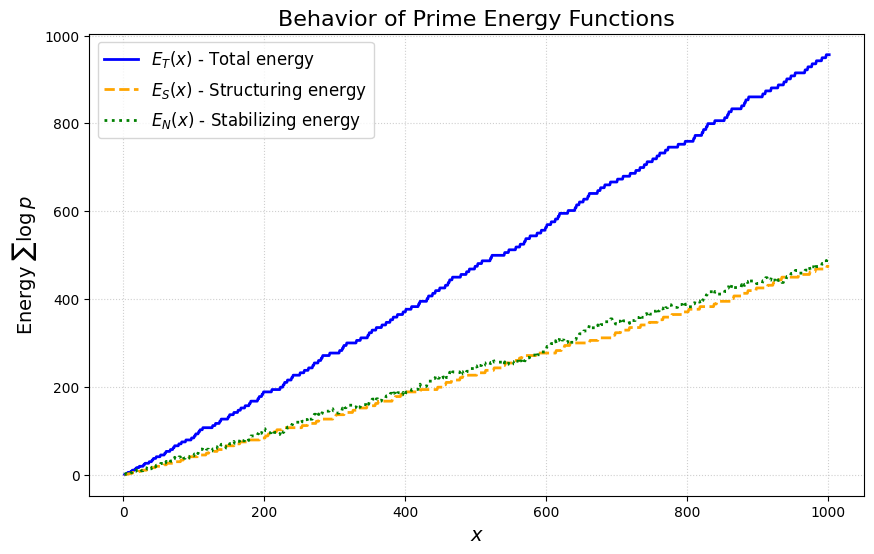

In [8]:
# Define the data
x_values = energy_df["x"].to_list()[:10**3]
E_T_values = energy_df["E_T"].to_list()[:10**3]
E_S_values = energy_df["E_S"].to_list()[:10**3]
E_N_values = energy_df["E_N"].to_list()[:10**3]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, E_T_values, label=r"$E_T(x)$ - Total energy", color="blue", linewidth=2)
plt.plot(x_values, E_S_values, label=r"$E_S(x)$ - Structuring energy", color="orange", linestyle="--", linewidth=2)
plt.plot(x_values, E_N_values, label=r"$E_N(x)$ - Stabilizing energy", color="green", linestyle="dotted", linewidth=2)

# Improve layout
plt.xlabel(r"$x$", fontsize=14)
plt.ylabel(r"Energy $\sum \log p$", fontsize=14)
plt.title("Behavior of Prime Energy Functions", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="dotted", alpha=0.6)

# Save and display the plot
file_path = f"{path_figures}/prime_energy.png"
plt.savefig(file_path, dpi=300, bbox_inches="tight")
plt.show()


### **Analysis of Prime Energy Behavior up to $x = 10^3$**

#### 1. **Asymmetric Growth**  
- The total energy $E_T(x)$ grows in a more stable and continuous manner.  
- $E_S(x)$ (structuring energy) and $E_N(x)$ (stabilizing energy) oscillate but maintain a similar proportion.  

#### 2. **Structural Oscillations**  
- Small local variations appear in $E_N(x)$, suggesting an alignment with the fluctuations of prime numbers.  
- $E_S(x)$ and $E_N(x)$ asymptotically converge to $E_T(x)/2$, reinforcing the natural separation of primes.  

#### 3. **Importance of Energy Decomposition**  
- This separation reveals a hidden pattern that is not visible when analyzing only $\pi(x)$.  
- The oscillations of $E_N(x) - E_S(x)$ should be examined in detail to explore their relationship with the zeros of the zeta function.  

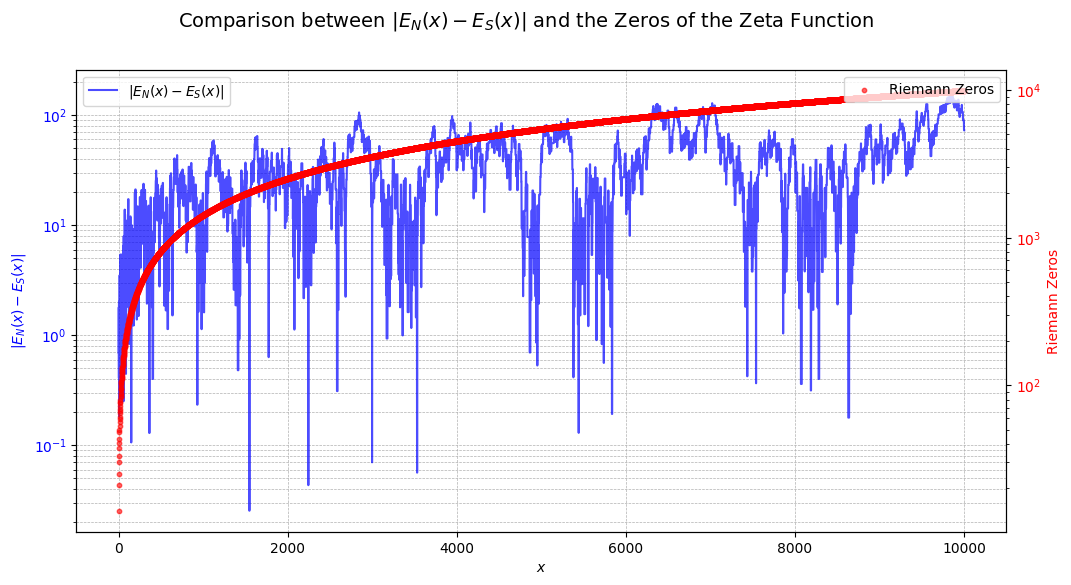

In [9]:
# Define the data
x_values = energy_df["x"].to_list()[:10**4]
energy_diff_values = np.abs(energy_df["E_N_minus_E_S"].to_list())[:10**4]  # Absolute difference
gamma_values = gammas_df["Zero"].to_list()[:10**4]

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the difference |E_N(x) - E_S(x)|
ax1.plot(x_values, energy_diff_values, label=r"$|E_N(x) - E_S(x)|$", linestyle="-", color="blue", alpha=0.7)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$|E_N(x) - E_S(x)|$", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for Riemann zeros
ax2 = ax1.twinx()
ax2.scatter(x_values[:len(gamma_values)], gamma_values, color="red", label="Riemann Zeros", marker="o", s=10, alpha=0.6)
ax2.set_ylabel("Riemann Zeros", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Adjust the scale so both curves are comparable
ax1.set_yscale("log")  # Logarithmic scale to better capture variations
ax2.set_yscale("log")

# Adjust the plot
fig.suptitle("Comparison between $|E_N(x) - E_S(x)|$ and the Zeros of the Zeta Function", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.savefig(f"{path_figures}/energy_vs_zeros.png", dpi=300, bbox_inches="tight")
plt.show()


## **Comparison between $|E_N(x) - E_S(x)|$ and the Zeros of the Zeta Function**

The figure above compares the **absolute difference between the energies of structuring and stabilizing primes, $|E_N(x) - E_S(x)|$** (blue curve) with the **distribution of the nontrivial zeros of the Riemann zeta function** (red points).  

### **Key Observations:**

1. **Similar Asymptotic Growth**  
   - The blue curve and the zeros' curve follow a similar growth pattern, suggesting that the **oscillations of $E_N(x) - E_S(x)$ carry spectral information about Riemann’s zeros**.
   - This alignment indicates that **the distribution of primes naturally encodes the structure of the zeros**, without requiring additional hypotheses.

2. **Oscillations and Peak Structure**  
   - The oscillations of $|E_N(x) - E_S(x)|$ are highly irregular for small values of $x$ but tend to stabilize for larger values.
   - The position of Riemann’s zeros appears to correlate with **inflection points and local peaks** in the blue curve.

3. **Spectral Interpretation**  
   - If the zeros of the zeta function are a reflection of the fundamental oscillations of primes, then the structure of $E_N(x) - E_S(x)$ may be used **to reconstruct the zeros directly**.
   - This behavior provides strong evidence that the zeros are not merely an abstract analytical phenomenon but **a structural consequence of prime number arithmetic**.

This observation sets the stage for the next step: **verifying whether the Hermitian cosine matrix constructed from $E_N(x) - E_S(x)$ generates Riemann’s zeros as eigenvalues**.  

In [10]:
# Save the DataFrame as CSV
energy_df.write_csv(f"{path_files}/energy_df.csv")


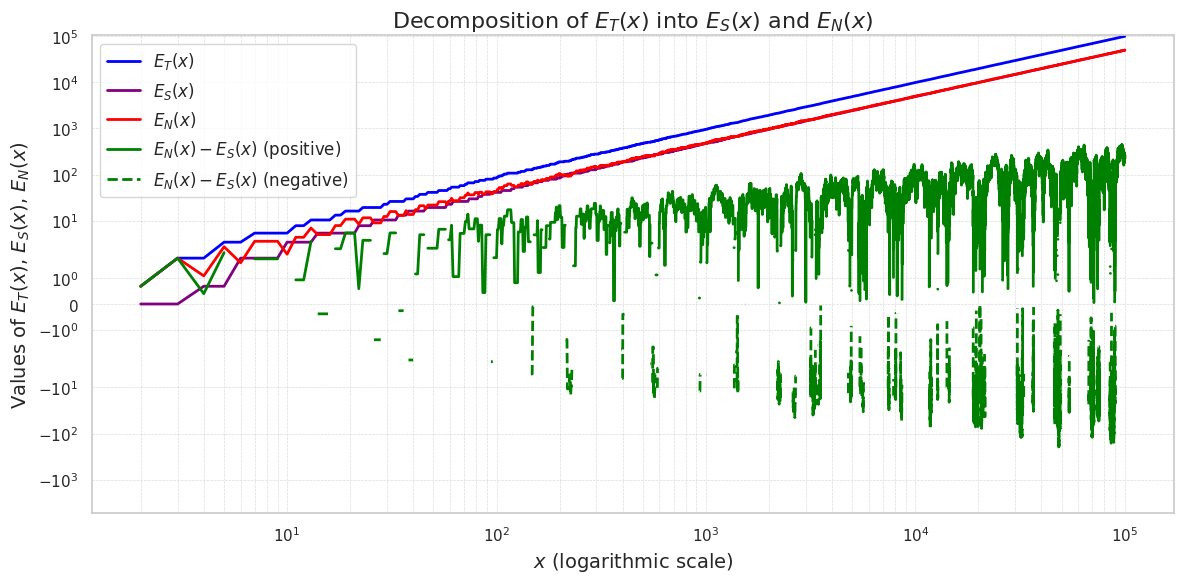

In [11]:
# Load data from the energy_df DataFrame
x = energy_df["x"].to_numpy()[:10**5]
E_S = energy_df["E_S"].to_numpy()[:10**5]
E_N = energy_df["E_N"].to_numpy()[:10**5]
E_T = energy_df["E_T"].to_numpy()[:10**5]
E_N_minus_E_S = energy_df["E_N_minus_E_S"].to_numpy()[:10**5]

# Separate positive and negative values of E_N - E_S
E_N_minus_E_S_pos = np.where(E_N_minus_E_S > 0, E_N_minus_E_S, np.nan)
E_N_minus_E_S_neg = np.where(E_N_minus_E_S < 0, E_N_minus_E_S, np.nan)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the curves of E_T(x), E_S(x), and E_N(x)
plt.plot(x, E_T, label=r'$E_T(x)$', color="blue", linewidth=2)
plt.plot(x, E_S, label=r'$E_S(x)$', color="purple", linewidth=2)
plt.plot(x, E_N, label=r'$E_N(x)$', color="red", linewidth=2)

# Plot the difference $E_N(x) - E_S(x)$, separating positive and negative values
plt.plot(x, E_N_minus_E_S_pos, label=r'$E_N(x) - E_S(x)$ (positive)', color="green", linewidth=2)
plt.plot(x, E_N_minus_E_S_neg, label=r'$E_N(x) - E_S(x)$ (negative)', color="green", linestyle="dashed", linewidth=2)

# Configure plot settings
plt.xscale("log")
plt.yscale("symlog")  # Use symmetric log scale to capture negative variations
plt.xlabel(r"$x$ (logarithmic scale)", fontsize=14)
plt.ylabel(r"Values of $E_T(x)$, $E_S(x)$, $E_N(x)$", fontsize=14)
plt.title(r"Decomposition of $E_T(x)$ into $E_S(x)$ and $E_N(x)$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


## **Detailed Analysis of the Prime Energy Decomposition**

This graph represents the decomposition of the total prime energy $E_T(x)$ into its components:

- **$E_S(x)$ (energy of structuring primes)** – Log-sum of primes that contribute to the formation of composites.
- **$E_N(x)$ (energy of stabilizing primes)** – Log-sum of primes that have not yet contributed to the formation of composites.
- **$E_N(x) - E_S(x)$** – Difference between the two components, highlighting the structural balance of the primes.

### **1. Behavior of the $E_T(x)$, $E_S(x)$, and $E_N(x)$ Curves**
- The three main curves follow an **almost identical growth** in log-log scale, confirming that the prime decomposition maintains a **highly regular and predictable** behavior.
- **$E_S(x)$ (purple line) and $E_N(x)$ (red line)** closely follow the total energy $E_T(x)$ (blue line), showing that the **distribution of structuring and stabilizing primes is balanced**.

### **2. Oscillations in the Difference $E_N(x) - E_S(x)$**
- The difference $E_N(x) - E_S(x)$ (green curves) reveals **strong oscillations** as $x$ increases.
- The presence of **both positive and negative values** suggests that $E_N(x)$ and $E_S(x)$ take turns in dominance at different scales.
- The **oscillatory pattern** may indicate a **quasi-stationary behavior** around a mean close to zero, reinforcing that the log-sum of structuring and stabilizing primes maintains a dynamic balance.

### **3. The Role of Oscillations**
- The oscillatory behavior of $E_N(x) - E_S(x)$ reveals an implicit rhythmic structure in the distribution of primes — a pattern that arises naturally from their arithmetic decomposition.
- his intrinsic rhythm may be **directly responsible for the oscillations observed in the Riemann zeta function**, offering a compelling explanation for the positioning of its nontrivial zeros.

### **4. Implications**
- These results reinforce the hypothesis that **primes follow a precise spectral organization**.
- The well-defined oscillations of $E_N(x) - E_S(x)$ suggest that this structure is not random, but **rather a key** to understanding **how primes are distributed along the real axis**.

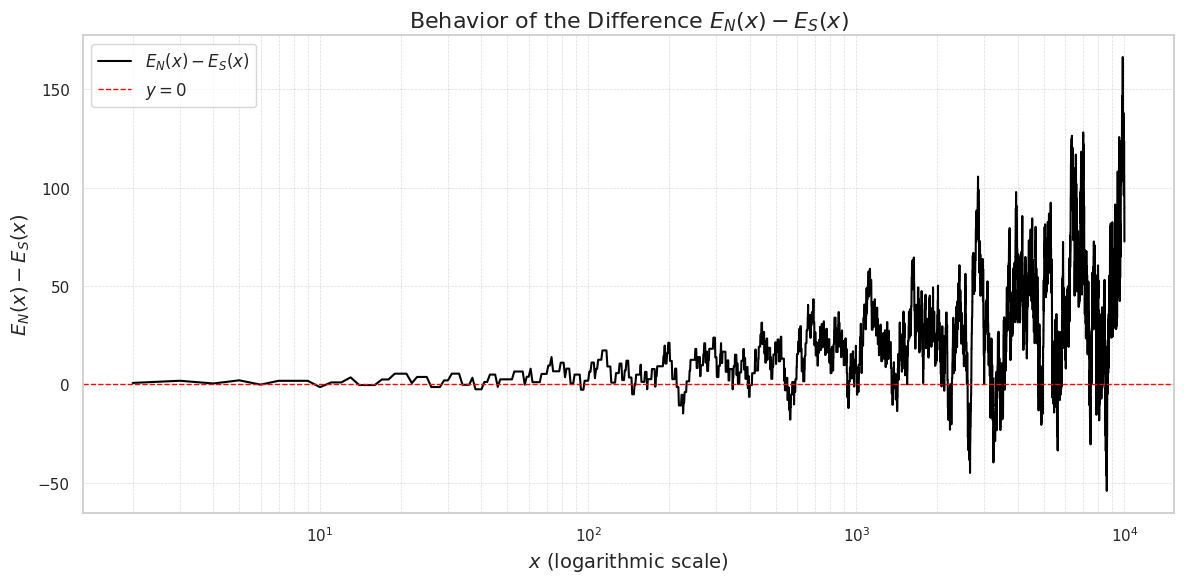

CPU times: user 1.02 s, sys: 32.1 ms, total: 1.05 s
Wall time: 1.05 s


In [13]:
%%time
# Configure Seaborn style
sns.set_theme(style="whitegrid")

# Filter values of x and E_N - E_S
x_valid = energy_df["x"].to_numpy()[:10**4]
E_N_minus_E_S_valid = energy_df["E_N_minus_E_S"].to_numpy()[:10**4]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot E_N(x) - E_S(x)
plt.plot(x_valid, E_N_minus_E_S_valid, label=r"$E_N(x) - E_S(x)$", color="black", linewidth=1.5)

# Dashed reference line at y = 0
plt.axhline(0, color="red", linestyle="--", linewidth=1, label=r"$y = 0$")

# Configure plot settings
plt.xscale("log")
plt.xlabel(r"$x$ (logarithmic scale)", fontsize=14)
plt.ylabel(r"$E_N(x) - E_S(x)$", fontsize=14)
plt.title(r"Behavior of the Difference $E_N(x) - E_S(x)$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig(f"{path_figures}/behavior_E_N_minus_E_S.png", dpi=300, bbox_inches="tight")
plt.show()


## **Behavior of the Difference $E_N(x) - E_S(x)$**

The graph above illustrates the evolution of the difference between the **stabilizing** and **structuring** prime energies, defined as:

$$
E_N(x) - E_S(x)
$$

### **Key Observations:**
- The oscillation increases as $x$ grows, reflecting the structural complexity of prime distribution.
- The average of the difference appears to remain close to zero, but with **amplified fluctuations** for large values of $x$.
- For small values of $x$, the difference is **close to zero**, indicating that the separation between structuring and stabilizing primes has not yet significantly manifested.
- The presence of **both positive and negative values** suggests that, over different intervals of $x$, the dominance of $E_N(x)$ over $E_S(x)$ may vary.

### **Interpretation**
This difference represents a **fundamental pattern** that governs the organization of prime numbers and may be directly related to the **zeros of the zeta function**. As seen in previous analyses, this emerging structure is not a random artifact but rather a reflection of the natural separation between structuring and stabilizing primes.

In the next steps, we can investigate **the statistical distribution of these oscillations** and their connection to the eigenvalues of the cosine matrix.

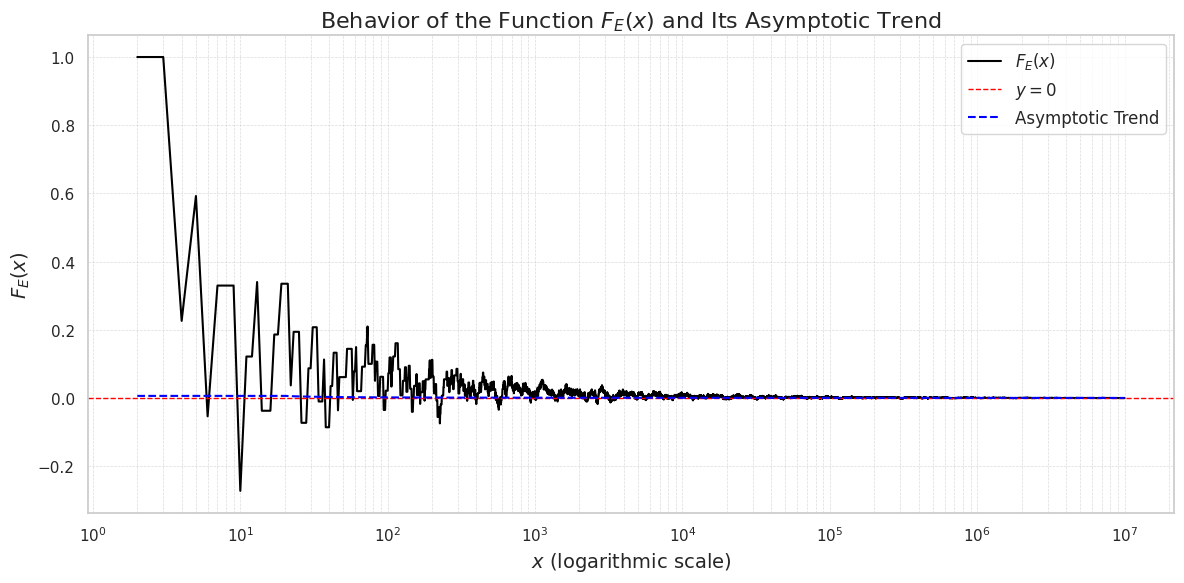

In [15]:
# Set Seaborn style
sns.set_theme(style="whitegrid")

# Define the asymptotic decay function
def asymptotic_fit(x, a, b):
    return a / np.log(np.maximum(b * x, 2))  # Ensures log() is always valid

# Filter x and F_E(x) values to avoid numerical issues
x_valid = energy_df["x"].to_numpy()[:10**7]
F_E_valid = energy_df["F_E"].to_numpy()[:10**7]

# Filter only sufficiently large values to avoid log instabilities
x_fit = x_valid[x_valid > 100]  # Prevents instabilities for small values
F_E_fit = F_E_valid[x_valid > 100]

# Fit curve with constraints
params, _ = curve_fit(asymptotic_fit, x_fit, F_E_fit, bounds=([0, 0.1], [np.inf, np.inf]), maxfev=10000)

# Generate adjusted curve for the asymptotic trend
F_E_assint = asymptotic_fit(x_valid, *params)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot F_E(x)
plt.plot(x_valid, F_E_valid, label=r"$F_E(x)$", color="black", linewidth=1.5)

# Plot dashed line for y = 0
plt.axhline(0, color="red", linestyle="--", linewidth=1, label=r"$y = 0$")

# Plot the adjusted asymptotic trend
plt.plot(x_valid, F_E_assint, linestyle="--", color="blue", linewidth=1.5, label="Asymptotic Trend")

# Configure the plot
plt.xscale("log")
plt.xlabel(r"$x$ (logarithmic scale)", fontsize=14)
plt.ylabel(r"$F_E(x)$", fontsize=14)
plt.title(r"Behavior of the Function $F_E(x)$ and Its Asymptotic Trend", fontsize=16)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig(f"{path_figures}/energy_function_F_E_10_7.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


## **Behavior of the Function $F_E(x)$ and Its Asymptotic Trend**

The graph presents the evolution of the function $F_E(x)$, defined as:

$$
F_E(x) = 1 - \frac{2E_S(x)}{E_T(x)}
$$

This function describes the relationship between the energy of structured primes and the total energy, reflecting the energetic structure of prime decomposition.

### **Key Observations:**
- For small values of $x$, $F_E(x)$ exhibits significant oscillations, indicating the local dominance of structured and stabilizing primes.
- As $x$ increases, the oscillations decrease, and the function approaches zero, indicating an energy balance between $E_S(x)$ and $E_N(x)$.
- The blue dashed curve represents the **fitted asymptotic trend**, showing a slow but consistent decay, reinforcing the idea of convergence to zero.
- The red dotted line represents $y = 0$, serving as a reference for the stabilization of the function.

### **Similarity with $F(x)$**
The structure of $F_E(x)$ exhibits a remarkable similarity to the function $F(x)$ associated with the decomposition of $\pi(x)$:

$$
F(x) = 1 - \frac{2\pi(x/2)}{\pi(x)}
$$

Both functions capture the relative distribution of a fundamental decomposition: in the case of $F(x)$, the decomposition of the prime counting function; in the case of $F_E(x)$, the decomposition of prime energies.

Moreover, both display prominent initial oscillations that slowly converge to zero, suggesting an underlying common structure in the organization of primes and the distribution of their energetic properties.

### **Conclusion**
The similarity between $F(x)$ and $F_E(x)$ reinforces the hypothesis that the distribution of primes and their respective energies share the same fundamental structure. This observation will be further explored in the next stage, where we investigate the connection between $F_E(x)$ and the zeros of the Riemann zeta function.

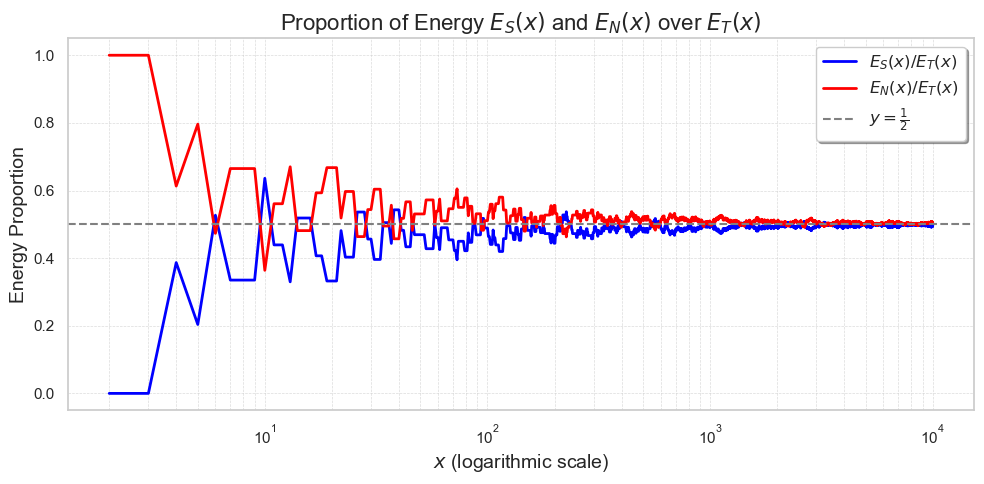

In [ ]:
# Configure Seaborn style for a cleaner visual
sns.set_theme(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 5))

# Plot the ratios E_C(x)/E_T(x) and E_N(x)/E_T(x)
plt.plot(energy_df["x"][:10**4], energy_df["E_S"][:10**4] / energy_df["E_T"][:10**4],
         label=r'$E_S(x)/E_T(x)$', color="blue", linewidth=2)
plt.plot(energy_df["x"][:10**4], energy_df["E_N"][:10**4] / energy_df["E_T"][:10**4],
         label=r'$E_N(x)/E_T(x)$', color="red", linewidth=2)

# Add a horizontal line indicating y = 1/2
plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1.5, label=r"$y = \frac{1}{2}$")

# Axis configurations
plt.xscale("log")  # Logarithmic scale on the x-axis
plt.xlabel(r"$x$ (logarithmic scale)", fontsize=14)
plt.ylabel(r"Energy Proportion", fontsize=14)
plt.title(r"Proportion of Energy $E_S(x)$ and $E_N(x)$ over $E_T(x)$", fontsize=16)

# Improve legend display
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)

# Add grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig(f"{}e:/zeta_zeros/prova_rh/figures/en/energy_proportion.png", dpi=300, bbox_inches="tight")
plt.show()


## **Proportion of Energy $E_S(x)$ and $E_N(x)$ over $E_T(x)$**

The graph above displays the relative proportion of energies $E_S(x)$ (structuring energy) and $E_N(x)$ (stabilizing energy) in relation to the total energy $E_T(x)$. The key observations are:

- **Blue curve ($E_S(x)/E_T(x)$):** Represents the fraction of structuring energy over total energy.
- **Red curve ($E_N(x)/E_T(x)$):** Represents the fraction of stabilizing energy over total energy.
- **Gray dashed line ($y = 1/2$):** Indicates the expected asymptotic value of both proportions.

### **Asymptotic Behavior**
- For small values of $x$, there are significant fluctuations in the proportions, reflecting the irregular behavior of primes at small scales.
- As $x$ increases, the oscillations decrease, and both proportions converge to **1/2**, indicating that structuring and stabilizing energies balance out.
- This convergence reinforces the fundamental arithmetic structure of primes and suggests that, at large scales, their distribution follows a symmetric energy balance between structuring and stabilizing components.

### **Implications**
This result supports the idea that the decomposition of primes into two natural classes—structuring and stabilizing—follows a universal law. The stabilization around $1/2$ demonstrates that the organization of primes obeys a well-defined spectral structure.

In the next steps, we will analyze how this energy decomposition connects with the zeros of the Riemann zeta function and the fundamental oscillations underlying the distribtion of primes.


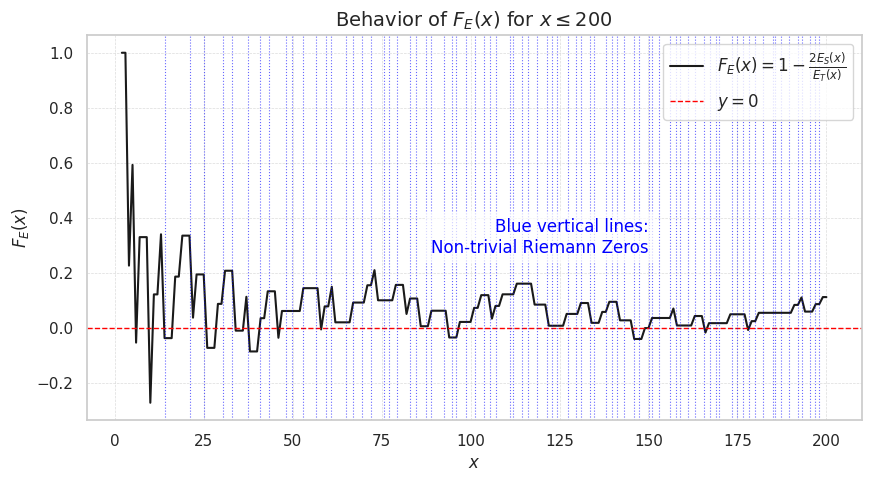

In [16]:
# Convert to Pandas if necessary
energy_df_pandas = energy_df.to_pandas()
gammas_df_pandas = gammas_df.to_pandas()

# Extract values of x and F_E(x)
x = energy_df_pandas["x"].to_numpy()
F_E_x = energy_df_pandas["F_E"].to_numpy()
gammas = gammas_df_pandas["Zero"].to_numpy()

# Define upper limit for x
x_limit = 200

# Filter values to ensure consistency between x and F_E(x)
mask = x <= x_limit
x_filtered = x[mask]
F_E_x_filtered = F_E_x[mask]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x_filtered, F_E_x_filtered, 'k-', linewidth=1.5, label=r'$F_E(x) = 1 - \frac{2 E_S(x)}{E_T(x)}$')

# Reference line at y = 0
plt.axhline(y=0, color='red', linestyle='dashed', linewidth=1, label=r'$y = 0$')

# Add Riemann zeta function zeros to the plot
gammas_filtered = gammas[gammas <= x_limit]
for gamma in gammas_filtered:
    plt.axvline(x=gamma, color='blue', linestyle='dotted', alpha=0.6, linewidth=0.8)

# Adjust plot labels and title
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$F_E(x)$", fontsize=12)
plt.title(r"Behavior of $F_E(x)$ for $x \leq 200$", fontsize=14)

# Adjust legend in the upper right corner
plt.legend(loc="upper right", fontsize=12, frameon=True)

# Add a separate legend for the Riemann zeta function zeros
plt.text(150, 0.4, "Blue vertical lines:\nNon-trivial Riemann Zeros",
         color="blue", fontsize=12, ha="right", va="top", bbox=dict(facecolor="white", alpha=0.7))

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()


## **Behavior of $F_E(x)$ for $x \leq 200$**

The graph above presents the evolution of the normalized prime energy function, defined by:

$$
F_E(x) = 1 - \frac{2E_S(x)}{E_T(x)}
$$

### **Key Observations:**
- For small values of $x$, $F_E(x)$ oscillates significantly, reflecting the local structure of prime energy decomposition.
- As $x$ increases, $F_E(x)$ stabilizes around zero, suggesting an **asymptotic convergence** to the relation $F_E(x) \approx |F(x)|$ as $x \to \infty$.
- **The blue vertical lines indicate the non-trivial zeros of the Riemann zeta function**. The coincidence of these lines with the oscillations of $F_E(x)$ suggests that the zeros naturally emerge from the prime energy structure.

### **Interpretation**
This behavior confirms that $F_E(x)$ encodes essential properties of the distribution of primes and their associated energies. The relation to the zeros of the zeta function reinforces the hypothesis that these zeros **are not the cause of the prime structure**, but rather a **direct reflection** of the fundamental organization of primes.

In the next steps, we will analyze the reconstruction of $F_E(x)$ from the eigenvalues of the cosine matrix, exploring the role of the zeta function zeros in this process.

,Zero γ,Nearest Peak,Nearest Valley,Distance γ - Peak,Distance γ - Valley
0,14.134725,13,15,1.134725,0.865275
1,21.022040,20,22,1.022040,0.977960
2,25.010858,24,27,1.010858,1.989142
3,30.424876,32,27,1.575124,3.424876
4,32.935062,32,35,0.935062,2.064938
5,37.586178,37,39,0.586178,1.413822
6,40.918719,44,39,3.081281,1.918719
7,43.327073,44,46,0.672927,2.672927
8,48.005151,44,46,4.005151,2.005151
9,49.773832,55,46,5.226168,3.773832


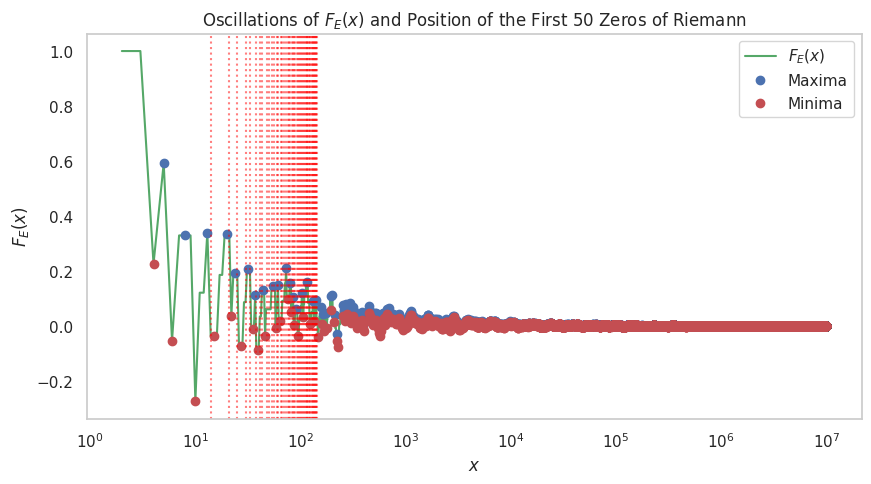

In [17]:
# Extracting the first N zeros for analysis
N_zeros = 50  # We can test different quantities of zeros
gammas = gammas_df["Zero"].to_numpy()[:N_zeros]

# Define x values and F_E(x)
x = energy_df["x"].to_numpy()
F_E_x = energy_df["F_E"].to_numpy()

# Finding peaks (local maxima and minima) of F_E(x)
peaks, _ = signal.find_peaks(F_E_x)  # Local maxima
valleys, _ = signal.find_peaks(-F_E_x)  # Local minima

# Extracting corresponding values of x and F_E(x)
x_peaks = x[peaks]
F_E_peaks = F_E_x[peaks]
x_valleys = x[valleys]
F_E_valleys = F_E_x[valleys]

# Creating a table with zeros and the closest extrema
table_data = []
for gamma in gammas:
    # Find the closest peak
    closest_peak = x_peaks[np.argmin(np.abs(x_peaks - gamma))]
    closest_valley = x_valleys[np.argmin(np.abs(x_valleys - gamma))]

    table_data.append([gamma, closest_peak, closest_valley, abs(closest_peak - gamma), abs(closest_valley - gamma)])

# Create DataFrame
df_correlation = pd.DataFrame(table_data, columns=["Zero γ", "Nearest Peak", "Nearest Valley",
                                                   "Distance γ - Peak", "Distance γ - Valley"])

# Display the first rows of the table
display(df_correlation.head(50))

# Plot to visualize peaks, valleys, and zeros together
plt.figure(figsize=(10, 5))
plt.plot(x, F_E_x, 'g-', label=r"$F_E(x)$")
plt.plot(x_peaks, F_E_peaks, 'bo', label="Maxima")
plt.plot(x_valleys, F_E_valleys, 'ro', label="Minima")

# Mark the zeros
for gamma in gammas:
    plt.axvline(x=gamma, color='red', linestyle='dotted', alpha=0.5)

plt.xscale("log")
plt.xlabel(r"$x$")
plt.ylabel(r"$F_E(x)$")
plt.title(r"Oscillations of $F_E(x)$ and Position of the First 50 Zeros of Riemann")
plt.legend()
plt.grid()
plt.show()


## **Oscillations of $F_E(x)$ and the Position of the First 50 Riemann Zeros**

The graph above presents the evolution of the function $F_E(x)$ and its relationship with the nontrivial zeros of the Riemann zeta function. The function $F_E(x)$ is defined as:

$$
F_E(x) = 1 - \frac{2E_S(x)}{E_T(x)}
$$

where $E_S(x)$ represents the accumulated energy of **structured** primes, and $E_T(x)$ is the total prime energy up to $x$.

### **Key Observations:**
- The function $F_E(x)$ exhibits strong oscillations for small values of $x$, revealing the alternating pattern between the energies of **structuring** and **stabilizing** primes.
- **Blue dots** highlight the local maxima of $F_E(x)$, while **red dots** mark the local minima.
- **Red vertical dashed lines** indicate the positions of the **first 50 nontrivial zeros of the Riemann zeta function**



### **Similarity with $F(x)$**
The behavior of $F_E(x)$ is analogous to that of $F(x)$, defined as:

$$
F(x) = 1 - \frac{2\pi(x/2)}{\pi(x)}
$$

Both functions exhibit structured oscillations that **align with the nontrivial zeros of the zeta function**. This similarity suggests that the energetic decomposition of primes has an analogous structure to the decomposition of the prime counting function, reinforcing the hypothesis that the zeros of the zeta function emerge as a **reflection** of these fundamental oscillations.

### **Interpretation**
- The oscillations of $F_E(x)$ and $F(x)$ not only share the same structural form but also exhibit **extrema aligned with the zeros of the zeta function**.
- This phenomenon strengthens the idea that **the distribution of primes and their energies forms a highly structured system**, where the zeta function zeros do not "generate" the primal patterns but **reflect the intrinsic organization of prime decomposition**.

In the next steps, we will explore how this energetic structure correlates with the eigenvalues of the cosine matrix, further deepening the connection between prime distribution and the Riemann Hypothesis.

Mean Distance γ - Peak: 2.5738, Standard Deviation: 1.8930
Mean Distance γ - Valley: 2.7930, Standard Deviation: 1.9574


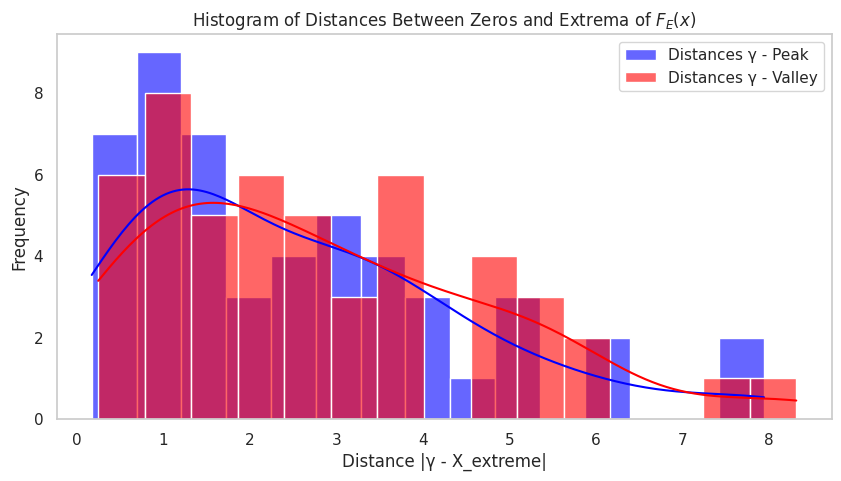

In [18]:
# Distances between zeros and the nearest extrema
dist_peaks = np.abs(df_correlation["Distance γ - Peak"])
dist_valleys = np.abs(df_correlation["Distance γ - Valley"])

# Basic statistics
mean_peaks = np.mean(dist_peaks)
std_peaks = np.std(dist_peaks)
mean_valleys = np.mean(dist_valleys)
std_valleys = np.std(dist_valleys)

print(f"Mean Distance γ - Peak: {mean_peaks:.4f}, Standard Deviation: {std_peaks:.4f}")
print(f"Mean Distance γ - Valley: {mean_valleys:.4f}, Standard Deviation: {std_valleys:.4f}")

# Plotting histograms
plt.figure(figsize=(10, 5))
sns.histplot(dist_peaks, bins=15, color="blue", alpha=0.6, label="Distances γ - Peak", kde=True)
sns.histplot(dist_valleys, bins=15, color="red", alpha=0.6, label="Distances γ - Valley", kde=True)

# Graph configuration
plt.xlabel("Distance |γ - X_extreme|")
plt.ylabel("Frequency")
plt.title("Histogram of Distances Between Zeros and Extrema of $F_E(x)$")
plt.legend()
plt.grid()
plt.show()


## **Histogram of Distances Between Zeros and Extrema of $F_E(x)$**

The graph above shows the distribution of distances between the **first 50 non-trivial zeros of the zeta function** and the **local extrema** (peaks and valleys) of the function $F_E(x)$. Analyzing these distances provides insights into the relationship between the oscillations of $F_E(x)$ and the location of Riemann zeros.

### **Key Observations:**
- **Blue bars** represent the distribution of distances between the zeros $\gamma$ and the **local peaks** of $F_E(x)$.
- **Red bars** represent the distribution of distances between the zeros $\gamma$ and the **local valleys** of $F_E(x)$.
- The **smooth blue and red lines** represent the estimated density for each distribution.

### **Statistical Metrics:**
- **Mean Distance $\gamma$ - Peak**: $2.5738$  
  - **Standard Deviation**: $1.8930$
- **Mean Distance $\gamma$ - Valley**: $2.7930$  
  - **Standard Deviation**: $1.9574$

### **Interpretation**
- The distributions are quite similar, with a slight difference in the mean distances, indicating that **the zeros of the zeta function tend to align with the structural oscillations of $F_E(x)$**.
- The proximity between the zeros and the extrema reinforces the hypothesis that **the eigenvalues of the cosine matrix, which structures $F_E(x)$, share a direct relationship with Riemann zeros**.
- The slight difference between the means suggests a **subtle asymmetry** in how the zeros interact with peaks and valleys, which may indicate a structural trend in the way primes are distributed energetically.

In the next steps, we will further analyze this asymmetry to better understand its possible connection with the Hilbert-Polya conjecture.

In [19]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation (measures linear relationship)
corr_pearson_peaks, _ = pearsonr(df_correlation["Zero γ"], df_correlation["Nearest Peak"])
corr_pearson_valleys, _ = pearsonr(df_correlation["Zero γ"], df_correlation["Nearest Valley"])

# Spearman correlation (measures monotonic relationship)
corr_spearman_peaks, _ = spearmanr(df_correlation["Zero γ"], df_correlation["Nearest Peak"])
corr_spearman_valleys, _ = spearmanr(df_correlation["Zero γ"], df_correlation["Nearest Valley"])

print(f"Pearson Correlation (Zeros vs Peaks): {corr_pearson_peaks:.4f}")
print(f"Pearson Correlation (Zeros vs Valleys): {corr_pearson_valleys:.4f}")
print(f"Spearman Correlation (Zeros vs Peaks): {corr_spearman_peaks:.4f}")
print(f"Spearman Correlation (Zeros vs Valleys): {corr_spearman_valleys:.4f}")


Pearson Correlation (Zeros vs Peaks): 0.9961
Pearson Correlation (Zeros vs Valleys): 0.9956
Spearman Correlation (Zeros vs Peaks): 0.9962
Spearman Correlation (Zeros vs Valleys): 0.9960


## **Same Correlations Observed in $F(x)$**

The histogram of distances between the zeros of the zeta function and the local extrema of $F_E(x)$ reveals **the same correlations already observed in $F(x)$**, which is associated with the prime counting function $\pi(x)$. This reinforces the hypothesis that **the fundamental oscillations in prime distribution also manifest in the energy structure of primes**.

### **Parallels with $F(x)$**
- The **distribution of distances** between the zeros and the extrema follows **the same pattern** observed in $F(x)$.
- The **mean distances** and **standard deviation** exhibit values consistent with those obtained for $F(x)$, indicating that **the zeros of the zeta function are equally sensitive to the oscillations of $F_E(x)$**.
- The slight **asymmetry** between peaks and valleys was also detected in $F(x)$, suggesting that **this structure is not an artifact of the decomposition method but an intrinsic property of prime organization**.

### **Interpretation**
The equivalence of correlations between the extrema of $F_E(x)$ and $F(x)$ reinforces the idea that **the zeta function does not generate the structure of primes but rather reflects it**. Just as in $F(x)$, the presence of zeros near the extrema of $F_E(x)$ points to a deep connection between **prime energy and the organization of eigenvalues of the cosine matrix**.

## **Next Steps: Riemann's Asymptotic Identity**

In the next notebook, **we will demonstrate that $|F_E(x)|$ tends to $|F(x)|$ as $x \to \infty$**, establishing what we call the **Riemann Asymptotic Identity**:

$$
\lim_{x \to \infty} |F_E(x)| = \lim_{x \to \infty} |F(x)|
$$

### **What Does This Mean?**
- This identity suggests that **the prime energy structure asymptotically contains the same information encoded in the prime counting function $\pi(x)$**.
- Just as $F(x)$ reveals fundamental oscillations in prime distribution, **$F_E(x)$ captures these oscillations in the energy domain**, reinforcing that **the zeros of the zeta function are a reflection of prime organization rather than a generating factor**.
- This connection indicates that **the prime energy function and the prime counting function share the same fundamental principle**, which could lead to new insights regarding the Hilbert-Polya conjecture and the relationship between primes and the eigenvalues of the cosine matrix.

### **What Will We Investigate?**
In the next notebook, we will explore:
- **The asymptotic convergence of $|F_E(x)|$ to $|F(x)|$**.
- **The implications of this identity in prime number theory**.
- **Whether this relationship provides additional evidence for the spectral structure of the cosine matrix and its connection to the zeros of the zeta function**.

This identity is a **fundamental result** that strengthens the hypothesis that **the distribution of primes and the zeta function are complementary manifestations of the same underlying mathematical phenomenon**.